In [1]:
import os
import logging
import shutil
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


current_directory = os.getcwd()
path_components = current_directory.split(os.path.sep)
new_directory = os.path.sep.join(path_components[:-1])

sys.path.append(new_directory)

from Postcode import Postprocessing

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

results_dir = os.path.sep.join(path_components[:-2])
simulation_name = 'Main'
results_path = os.path.join(results_dir,'.results','TEST',simulation_name)
main_path = os.path.join(results_dir,'code')
# simulation_name = 'Main'
#results_path = os.path.join(results_dir,'code','results',simulation_name)                        
                         
import shutil
shutil.copyfile(os.path.join(results_path,simulation_name+'.py'), os.path.join(main_path,'S_test.py'))

print(main_path)
print(results_path)

c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\code
c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\.results\TEST\Main


In [2]:
from Model.Mesh.Molecule_Mesh import Molecule_Mesh
from Model.PDE_Model import PBE
from NN.NeuralNet import NeuralNet
from NN.PINN import PINN 
from NN.XPINN import XPINN

folder_name = 'Main'
folder_path = os.path.join(main_path,'results',folder_name)


from S_test import PDE

sim = PDE()
N_points = {'dx_interior': 0.2,
                'dx_exterior': 0.5,
                'N_border': 6,
                'dx_experimental': 1,
                'N_pq': 10,
                }
for key,value in N_points.items():
    sim.N_points[key] = value

sim.create_simulation()

XPINN_solver = sim.XPINN_solver

In [3]:
Iter = 10
results_dir_iter = os.path.join(results_path,f'iter_{Iter}')
XPINN_solver.folder_path = folder_path
XPINN_solver.load_NeuralNets(results_dir_iter,['model_1','model_2'])
XPINN_solver.N_iters = XPINN_solver.iter
Post = Postprocessing(XPINN_solver, save=True, directory=folder_path)


c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\.venv\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning: NN.NeuralNet_Fourier is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(
c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\.venv\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning: NN.NeuralNet_Fourier is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


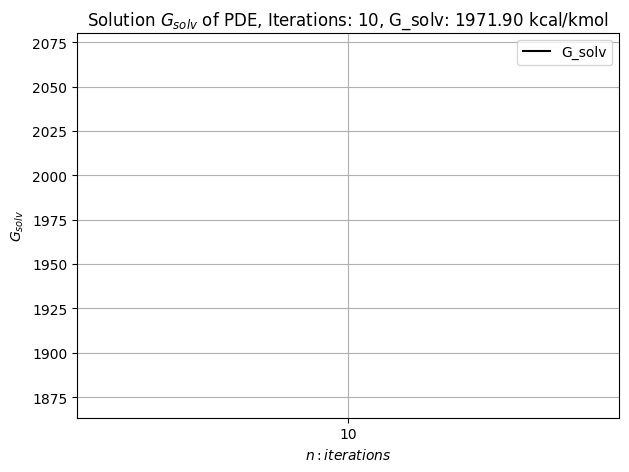

In [20]:
Post.plot_G_solv_history()

In [21]:
Post.plot_meshes_3D()
Post.plot_interface_3D('phi')
Post.plot_interface_3D('dphi')

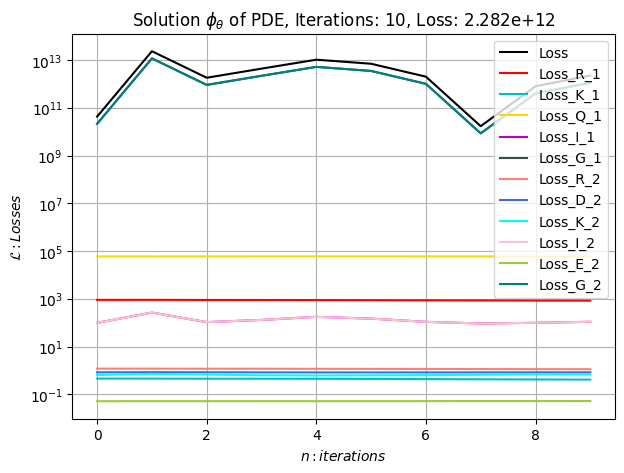

In [22]:
Post.plot_loss_history()

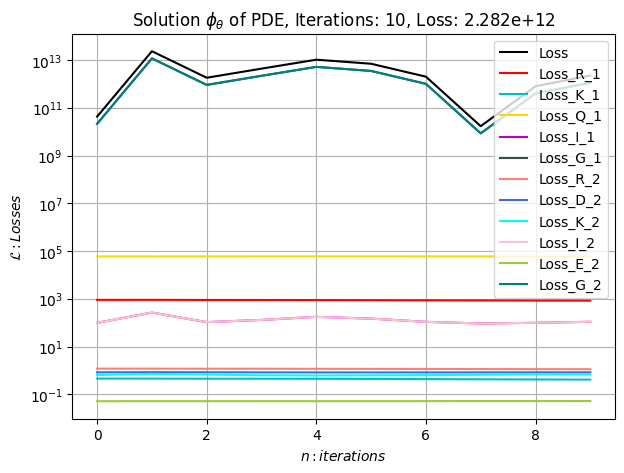

In [23]:
Post.plot_loss_history(plot_w=True)

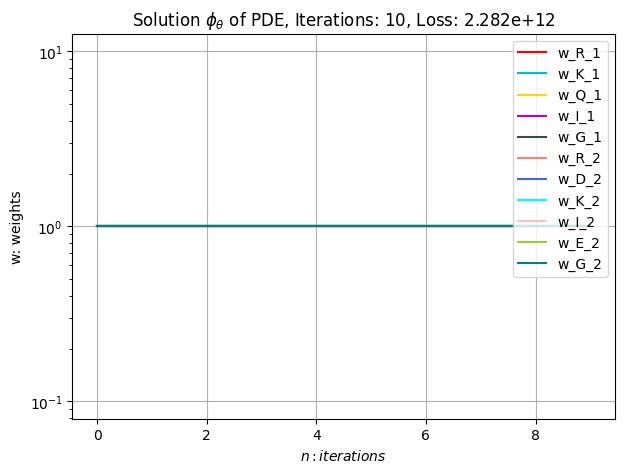

In [24]:
Post.plot_weights_history()

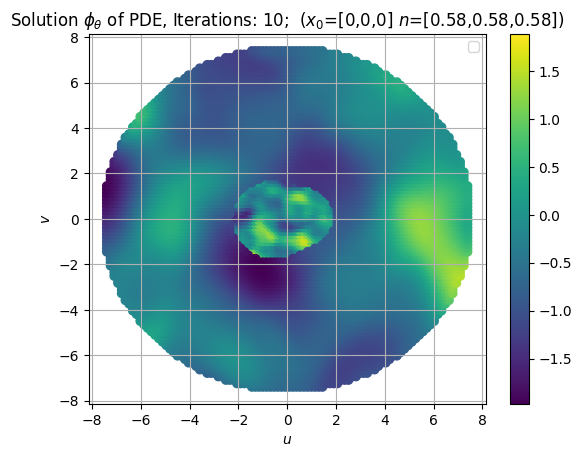

In [25]:
Post.plot_phi_contour(n=np.array([1,1,1]))

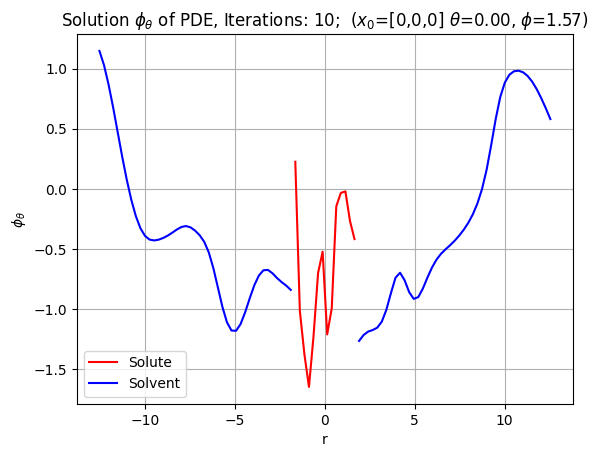

In [26]:
Post.plot_phi_line()